In [7]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt

from lstm import LSTM, lr_dict_scheduler, make_step
from data import DataLoader, normalize_data

# Params
feature_labels = ['Q']
target_label = 'SSC'
split_date = '2018-01-01'
num_samples = 5000
sequence_length = 14
batch_size = 64
num_epochs = 30
max_grad_norm = 1
hidden_size = 8

lr_schedule = {
    0: 0.01, 
    10: 0.005, 
    20: 0.001}

feature_size = len(feature_labels)
output_size = 1

data = pd.read_parquet("../data/synthetic_daily.parquet", engine='pyarrow')

# Split the dataset into training and testing sets based on the fixed date
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

# Normalize the training and testing data separately
train_norm, scale = normalize_data(train_data)
test_norm, _ = normalize_data(test_data, scale=scale)

# Use the dataloader to generate batches for the training set
train_dataloader_gen = DataLoader((train_norm[feature_labels].values, train_norm[target_label].values), batch_size, sequence_length,shuffle=False)

# Use the dataloader to generate batches for the testing set
test_dataloader_gen = DataLoader((test_norm[feature_labels].values, test_norm[target_label].values), batch_size, sequence_length, shuffle=False)


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

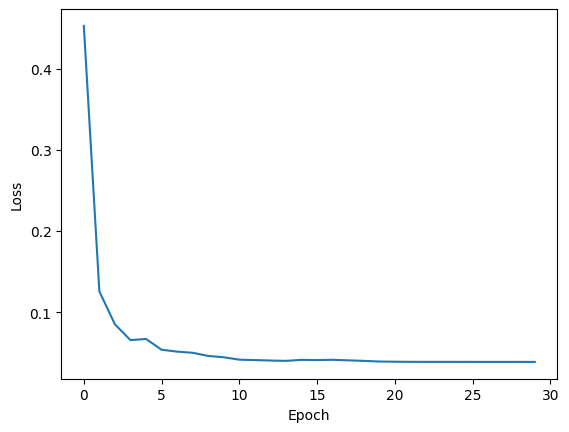

In [8]:
# Initialize the model
key = jax.random.PRNGKey(0)
model = LSTM(in_size=feature_size, 
             out_size=output_size, 
             hidden_size=hidden_size, 
             key=key)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    
    total_loss = 0
    num_batches = 0
    for x_batch, y_batch in train_dataloader_gen:
        loss, model, opt_state = make_step(model, x_batch, y_batch, opt_state, optim, max_grad_norm)
        total_loss += loss
        num_batches += 1
        if num_batches * batch_size >= num_samples:
            break
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

plt.close()
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

0it [00:00, ?it/s]

Text(0.5, 1.0, 'Test Data Predictions')

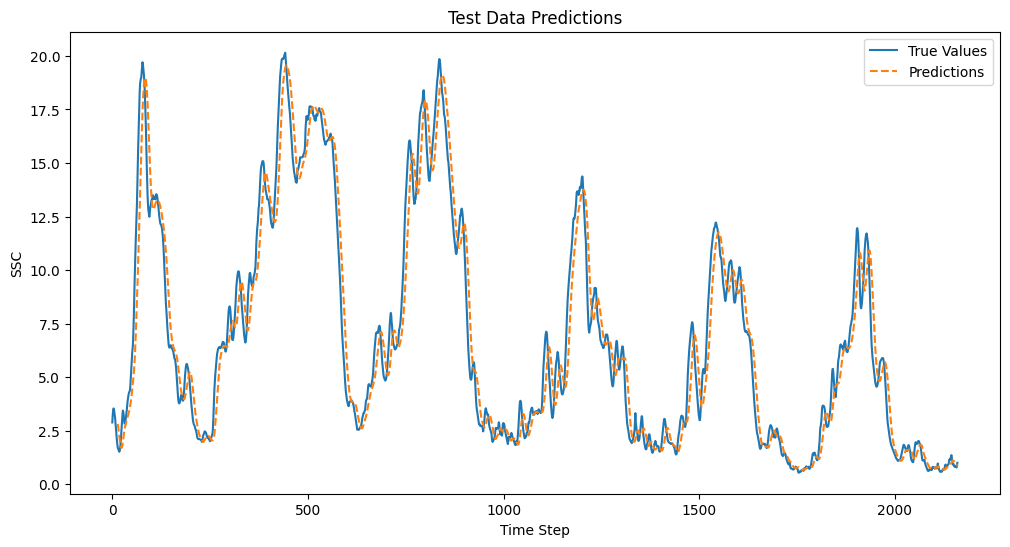

In [9]:
# Initialize lists to store predictions and true values
predictions = []

# Iterate over the test data
for x_batch, y_batch in tqdm(test_dataloader_gen):
    # Make predictions for the current batch
    pred = jax.vmap(model)(x_batch)
    predictions.extend(pred)

# # Convert lists to arrays
predictions = np.array(predictions).flatten()

rescaled_pred = predictions * scale['std'][target_label] + scale['mean'][target_label]
x_pred = range(sequence_length,len(predictions)+sequence_length)

# Plot the true values and predictions
plt.figure(figsize=(12, 6))
test_data.reset_index()[target_label].plot(label='True Values')
plt.plot(x_pred, rescaled_pred, label='Predictions', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel(target_label)
plt.legend()
plt.title('Test Data Predictions')